In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.6.3 requires fastcore<1.5,>=1.3.27, but you have fastcore 1.5.28 which is incompatible.


In [Iterate Like a Grandmaster](https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster) I explained that when working on a Kaggle project:

> ...the focus generally should be two things:
> 
> 1. Creating an effective validation set
> 2. Iterating rapidly to find changes which improve results on the validation set.

Here I'm going to go further, showing the process I used to tackle the [Paddy Doctor](https://www.kaggle.com/competitions/paddy-disease-classification) competition, leading to four submissions in a row which all were (at the time of submission) in 1st place, each one more accurate than the last. You might be surprised to discover that the process of doing this was nearly entirely mechanistic and didn't involve any consideration of the actual data or evaluation details at all.

This notebook is the first in a series showing every step of the process. At the end of this notebook we'll have a basic submission; by the end of the series you'll see how I got to the top of the table!:

<img src="https://user-images.githubusercontent.com/346999/174389920-60d67ead-0f36-41d0-9649-e23b08720c8a.png" width="600"/>

As a special extra, I'm also opening up early a selection of "walkthru" videos that we've been preparing for the new upcoming fast.ai course. Each day I do a walkthru with fast.ai fellows and registered students, and we record those sessions. They'll all be released at the same time as the next course (probably August 2022), but I'm releasing the ones covering this competition right now! Here they are:

- [Walkthru 8](https://www.youtube.com/watch?v=-Scs4gbwWXg)
- [Walkthru 9](https://www.youtube.com/watch?v=EK5wJRzffas)
- [Walkthru 10](https://youtu.be/zhBRynq9Yvo)
- [Walkthru 11](https://youtu.be/j-zMF2VirA8)
- [Walkthru 12](https://youtu.be/GuCkpjXHdTc)
- [Walkthru 13](https://youtu.be/INrkhUGCXHg)

When you're done with this notebook, take a look at [part 2 of the series](https://www.kaggle.com/code/jhoward/small-models-road-to-the-top-part-2/).

## Getting set up

First, we'll get the data. I've just created a new library called [fastkaggle](https://fastai.github.io/fastkaggle/) which has a few handy features, including getting the data for a competition correctly regardless of whether we're running on Kaggle or elsewhere. Note you'll need to first accept the competition rules and join the competition, and you'll need your kaggle API key file `kaggle.json` downloaded if you're running this somewhere other than on Kaggle. `setup_comp` is the function we use in `fastkaggle` to grab the data, and install or upgrade our needed python modules when we're running on Kaggle:

In [2]:
comp = 'paddy-disease-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.4 requires wrapt~=1.12.1, but you have wrapt 1.14.1 which is incompatible.
tensorflow-transform 1.8.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,<2.9,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.8.0 requires tensorflow<3,>=2.8.0, but you have tensorflow 2.6.4 which is incompatible.
rich 12.4.4 requires typing-extensions<5.0,>=4.0.0; python_version < "3.9", but you h

In [3]:
path

Path('../input/paddy-disease-classification')

Now we can import the stuff we'll need from fastai, set a seed (for reproducibility -- just for the purposes of making this notebook easier to write; I don't recommend doing that in your own analysis however) and check what's in the data:

In [4]:
from fastai.vision.all import *
set_seed(42)

path.ls()

(#4) [Path('../input/paddy-disease-classification/sample_submission.csv'),Path('../input/paddy-disease-classification/train_images'),Path('../input/paddy-disease-classification/train.csv'),Path('../input/paddy-disease-classification/test_images')]

## Looking at the data

The images are in `train_images`, so let's grab a list of all of them:

In [5]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

...and take a look at one:

(480, 640)


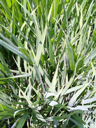

In [6]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

Looks like the images might be 480x640 -- let's check all their sizes. This is faster if we do it in parallel, so we'll use fastcore's `parallel` for this:

In [7]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

They're nearly all the same size, except for a few. Because of those few, however, we'll need to make sure we always resize each image to common dimensions first, otherwise fastai won't be able to create batches. For now, we'll just squish them to 480x480 images, and then once they're in batches we do a random resized crop down to a smaller size, along with the other default fastai augmentations provided by `aug_transforms`. We'll start out with small resized images, since we want to be able to iterate quickly:

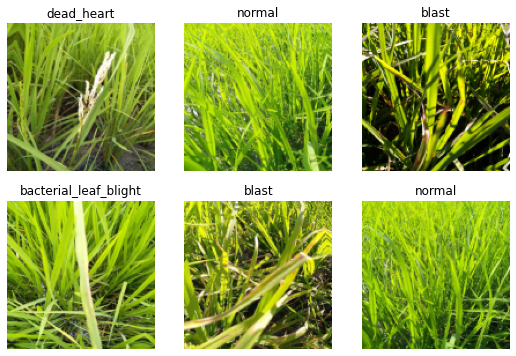

In [8]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

## Our first model

Let's create a model. To pick an architecture, we should look at the options in [The best vision models for fine-tuning](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning). I like the looks of `resnet26d`, which is the fastest resolution-independent model which gets into the top-15 lists there.

In [9]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


Let's see what the learning rate finder shows:

SuggestedLRs(valley=0.0008317637839354575, slide=0.007585775572806597)

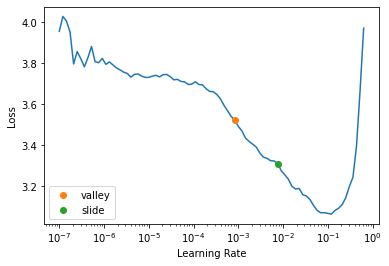

In [10]:
learn.lr_find(suggest_funcs=(valley, slide))

`lr_find` generally recommends rather conservative learning rates, to ensure that your model will train successfully. I generally like to push it a bit higher if I can. Let's train a few epochs and see how it looks:

In [11]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.795442,1.173954,0.370975,01:47


epoch,train_loss,valid_loss,error_rate,time
0,1.120635,0.739813,0.239308,01:50
1,0.769852,0.467970,0.153292,01:50
2,0.538296,0.370685,0.118212,02:16


We're now ready to build our first submission. Let's take a look at the sample Kaggle provided to see what it needs to look like:

## Submitting to Kaggle

In [12]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


OK so we need a CSV containing all the test images, in alphabetical order, and the predicted label for each one. We can create the needed test set using fastai like so:

In [13]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

We can now get the probabilities of each class, and the index of the most likely class, from this test set (the 2nd thing returned by `get_preds` are the targets, which are blank for a test set, so we discard them):

In [14]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

TensorBase([7, 8, 7,  ..., 8, 1, 5])

These need to be mapped to the names of each of these diseases, these names are stored by fastai automatically in the `vocab`:

In [15]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

We can create an apply this mapping using pandas:

In [16]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                       hispa
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

Kaggle expects the submission as a CSV file, so let's save it, and check the first few lines:

In [17]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,hispa
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


Let's submit this to kaggle. We can do it from the notebook if we're running on Kaggle, otherwise we can use the API:

In [18]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

Success! We successfully created a submission.

## Conclusion

Our initial submission is not very good (top 80% of teams) but it only took a minute to train. The important thing is that we have a good starting point to iterate from, and we can do rapid iterations. Every step from loading the data to creating the model to submitting to Kaggle is all automated and runs quickly.

Therefore, we can now try lots of things quickly and easily and use those experiments to improve our results. In the next notebook, we'll do exactly that! So if you're ready, take a look at [part 2 of the series](https://www.kaggle.com/code/jhoward/small-models-road-to-the-top-part-2/).

If you found this notebook useful, please remember to click the little up-arrow at the top to upvote it, since I like to know when people have found my work useful, and it helps others find it too. And if you have any questions or comments, please pop them below -- I read every comment I receive!

## Addendum

`fastkaggle` also provides a function that pushes a notebook to Kaggle Notebooks. I wrote this notebook on my own machine, and pushed it to Kaggle from there -- here's the command I used:

In [19]:
if not iskaggle:
    push_notebook('jhoward', 'first-steps-road-to-the-top-part-1',
                  title='First Steps: Road to the Top, Part 1',
                  file='first-steps-road-to-the-top-part-1.ipynb',
                  competition=comp, private=False, gpu=True)